In [129]:
import numpy as np
import random
from PIL import Image
from matplotlib.pyplot import imshow
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
from os import walk
from itertools import tee

%matplotlib inline

Указываем глобальные переменные:
- `SEED`: для случайных генераторов с целью воспроизводимости
- `MODE`: режим работы с картинкой **RGB**/**L** - цветной/черно-белый
- `S`: количество аргументов на пиксель (**3** - для цветного изображения, **1** - для черно-белого)
- `IMG_PATH`: путь к обрабатываемому изображению

In [130]:
SEED = 342323425
np.random.seed(SEED)
MODE = 'L'
S = 1
IMG_PATH = './rsz_pic3.jpg'

Метод загрузки картинки и преобразования в необходимый режим и размер

In [131]:
def load_image(path):
    img = Image.open(path)
    img = img.resize((128, 128))
    return img.convert(MODE)

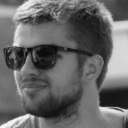

In [132]:
load_image(IMG_PATH)

Инициализация гиперпараметров: 
- `W`: ширина картинки
- `H`: высота картинки
- `n`: размер выреза (длина)
- `m`: размер выреза (ширина)
- `L`: количество нарезанных блоков
- `N`: размер вектора, конвертируемого из нарезанного блока

In [133]:
def init_hyperparams(im):
    W, H = im.size
    n, m = 16, 16
    L = H / n * W / m
    N = n * m * S
    return W, H, n, m, L, N, S

pic = load_image(IMG_PATH)
W, H, n, m, L, N, S = init_hyperparams(pic)
print W, H, L, N, S
# imshow(pic)

128 128 64 256 1


Методы преобразования картинки, генераторы нарезаемых блоков

In [134]:
def encode_pixel(P):
    C_MAX = 255.0
    P = np.array(P)
    return (2.0 * P / C_MAX) - 1.0

def encode_area(im, lu_corner, rb_corner):
    X0, Y0 = lu_corner
    X1, Y1 = rb_corner
    
    def transform(x, y):
        return encode_pixel(im.getpixel((x, y)))
    
    q = []
    for x in range(X0, X1 + 1):
        for y in range(Y0, Y1 + 1):
            q.append(transform(x, y))
    return np.array(q).flatten()

def decode_area(area):
    C_MAX = 255.0
    res = np.clip(np.int_(C_MAX * (area + 1.0) / 2.0), 0, 255)
    return res

def decode_image(areas):
    if S == 1:
        im_area = np.empty((H, W))
    else:
        im_area = np.empty((H, W, S))
    for i in range(H):
        for j in range(W):
            ii = i / n
            jj = j / m
            idx = ii * (W / m) + jj
            im_area[j][i] = decode_area(areas[idx][0][(i % n) * m + j % m:(i % n) * m + j % m + S])
    return Image.fromarray(im_area.astype('uint8'), mode=MODE)

def transform_random_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    while True:
        i = np.random.randint(im.height - n)
        j = np.random.randint(im.width - m)
        X = transform(i, j)
        yield X.reshape(1, len(X))
        

def transform_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    for i in range(0, im.height, n):
        for j in range(0, im.width, m):
            X = transform(i, j)
            yield X.reshape(1, len(X))

Подсчет коэффициента сжатия

In [135]:
def get_Z(N, L, p):
    return ((N + L) * p + 2.0) / (N * L)

In [136]:
# im = load_image(IMG_PATH)
# tr = transform_random_image(im, n, m)
# X = next(tr)
# print X.shape
# print X

Логика автокодировщика. Здесь используется метод инициализации весов `glorot_uniform` (https://keras.io/initializers/#glorot_uniform and http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). На вход можно подавать следующие параметры:
- `input_layers`: количество нейронов на входном слое (равно размеру вектора, вычисляемого из нарезанного блока)
- `lr`: learning rate
- `dynamic_lr`: флаг, отвечающий за динамический пересчет learning rate после каждой итерации, либо использовать переданное значение 
- `z`: коэффициент сжатия. Из него вычисляется количество нейронов на втором слое (`int(z * input_layers)`)
- `w_norm`: флаг, отвечающий за нормировку весов после каждой итерации

In [140]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6.0 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder(object):
    def __init__(self, input_layers=1000, lr=1e-2, dynamic_lr=True, z=0.9, w_norm=True):
        self.input_layers = input_layers
        self.mid_layers = int(z * input_layers)
        self.initializer = glorot_uniform(self.input_layers, self.mid_layers)
        self.lr = lr
        self.w_norm = w_norm
        self.dynamic_lr = dynamic_lr
        self.build()
        
    def error(self, err):
        return err**2
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.W1.T
    
    def __call__(self, gen, pbar=None):
        err = 0.0
        for inp in gen:
            mid, res = self.forward(inp)
            diff = res - inp
            err += self.error(diff).sum()
            self.backward(inp, mid, diff)
            if pbar:
                pbar.update(1)
        return err
    
    def forward(self, inp):
        mid = self.encode(inp, self.W1)
        return mid, self.decode(mid, self.W2)
    
    def backward(self, inp, mid, err):
        lr = self.lr
        if self.dynamic_lr:
            lr = 1.0 / np.dot(inp, inp.T)**2
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        if self.dynamic_lr:
            lr = 1.0 / np.dot(mid, mid.T)**2
        self.W2 -= lr * np.dot(mid.T, err)
        
        if self.w_norm:
            self.W2 /= np.linalg.norm(self.W2, axis=0, keepdims=True)
            self.W1 /= np.linalg.norm(self.W1, axis=1, keepdims=True)

    def encode(self, inp, W1):
        return np.dot(inp, W1)
    
    def decode(self, mid, W2):
        return np.dot(mid, W2)

Метод для запуска обучения для выбранной модели. Контролируются следующие параметры:
- `model`: настроенная модель
- `epochs`: ограничение сверху на количество запускаемых эпох
- `name`: используется для отрисовки названия графика "Количество эпох на ошибку"
- `th_err`: пороговое значение для ошибки
- `viz`: флаг, нужно ли рисовать график
- `ax`: переданный объект plot, на котором нужно рисовать график (следует передать `viz=True`)
- `gen`: генератор для блоков. По умолчанию генерируются блоки из стандартной картинки размера `n x m`
- `progress`: progress bar для визуализации прогресса
- `L`: количество блоков (используется для progress bar по умолчанию)

In [141]:
def try_run(model, epochs, name='', th_err=0.1, viz=True, ax=None, gen=None, progress=True, L=L):
    np.random.seed(SEED)
    errors = []
    if gen is None:
        im = load_image(IMG_PATH)
        gen = transform_image(im, n, m)
    gens = tee(gen, epochs)
    best_results = {
        'W1': None,
        'W2': None,
        'min_err': np.inf,
        'epoch': epochs,
    }

    def run_iters(pbar=None):
        epoch_run = 0
        err = np.inf
        min_err = np.inf
        cur_gen = 0
        while epoch_run < epochs and err > th_err:
            t_gen = gens[cur_gen]
            cur_gen += 1
            errors.append(model(t_gen, pbar))
            if errors[-1] < min_err:
                best_results['min_err'] = errors[-1]
                best_results['W1'] = model.W1
                best_results['W2'] = model.W2
                min_err = errors[-1]
            err = errors[-1]
            epoch_run += 1

        best_results['epoch'] = epoch_run

    if progress:
        with tqdm(total=epochs*L) as pbar:
            run_iters(pbar)
    else:
        run_iters()
    
    if viz:
        epoch = best_results['epoch']
        x = np.arange(epoch)
        idx = np.argmin(errors)
        print("BEST ERROR {} at {}".format(errors[idx], idx))
        
        if ax is None:
            plt.plot(x, np.array(errors))
            plt.title(name)
            plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
            plt.show()
        else:
            ax.plot(x, np.array(errors))
            ax.set_title(name)
            ax.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
    return best_results
    
def viz_encode(model, best_results, path=IMG_PATH):
    W1 = best_results['W1']
    W2 = best_results['W2']
    min_err = best_results['min_err']
    epoch = best_results['epoch']
    
    print 'Showing results for min_err={}. Epoch run: {}'.format(min_err, epoch)
    areas = []
    im = load_image(path)
    for area in transform_image(im, n, m):
        areas.append(model.decode(model.encode(area, W1), W2))
    areas = np.array(areas)
    new_pic = decode_image(areas)
    return new_pic

Запуск автокодировщика на стандартной картинке для разных коэффициентов сжатия. Пороговая ошибка $100.0$. Показ графика зависимости ошибки от коэффициента сжатия:

  0%|          | 86/25600 [00:00<00:29, 859.09it/s]

Running for z=0.1


100%|██████████| 25600/25600 [00:10<00:00, 2474.52it/s]


BEST ERROR 304590.78041 at 0
Showing results for min_err=304590.78041. Epoch run: 400


  0%|          | 47/25600 [00:00<00:55, 464.14it/s]

Min Error: 304590.78041
Running for z=0.233333333333


100%|██████████| 25600/25600 [00:15<00:00, 1636.12it/s]


BEST ERROR 162.977632026 at 399
Showing results for min_err=162.977632026. Epoch run: 400


  0%|          | 36/25600 [00:00<01:12, 354.62it/s]

Min Error: 162.977632026
Running for z=0.366666666667


 86%|████████▋ | 22080/25600 [00:18<00:02, 1222.88it/s]


BEST ERROR 99.9946719574 at 344
Showing results for min_err=99.9946719574. Epoch run: 345


  0%|          | 33/25600 [00:00<01:18, 325.89it/s]

Min Error: 99.9946719574
Running for z=0.5


 40%|████      | 10304/25600 [00:11<00:17, 897.94it/s]


BEST ERROR 99.9722536536 at 160
Showing results for min_err=99.9722536536. Epoch run: 161


  0%|          | 27/25600 [00:00<01:37, 263.13it/s]

Min Error: 99.9722536536
Running for z=0.633333333333


 26%|██▌       | 6528/25600 [00:07<00:22, 843.21it/s]


BEST ERROR 99.8108361028 at 101
Showing results for min_err=99.8108361028. Epoch run: 102


  0%|          | 39/25600 [00:00<01:05, 388.75it/s]

Min Error: 99.8108361028
Running for z=0.766666666667


 16%|█▋        | 4224/25600 [00:05<00:28, 759.28it/s]


BEST ERROR 99.9820248958 at 65
Showing results for min_err=99.9820248958. Epoch run: 66


  0%|          | 31/25600 [00:00<01:23, 304.41it/s]

Min Error: 99.9820248958
Running for z=0.9


 14%|█▎        | 3456/25600 [00:05<00:32, 684.42it/s]


BEST ERROR 99.0197829447 at 53
Showing results for min_err=99.0197829447. Epoch run: 54
Min Error: 99.0197829447


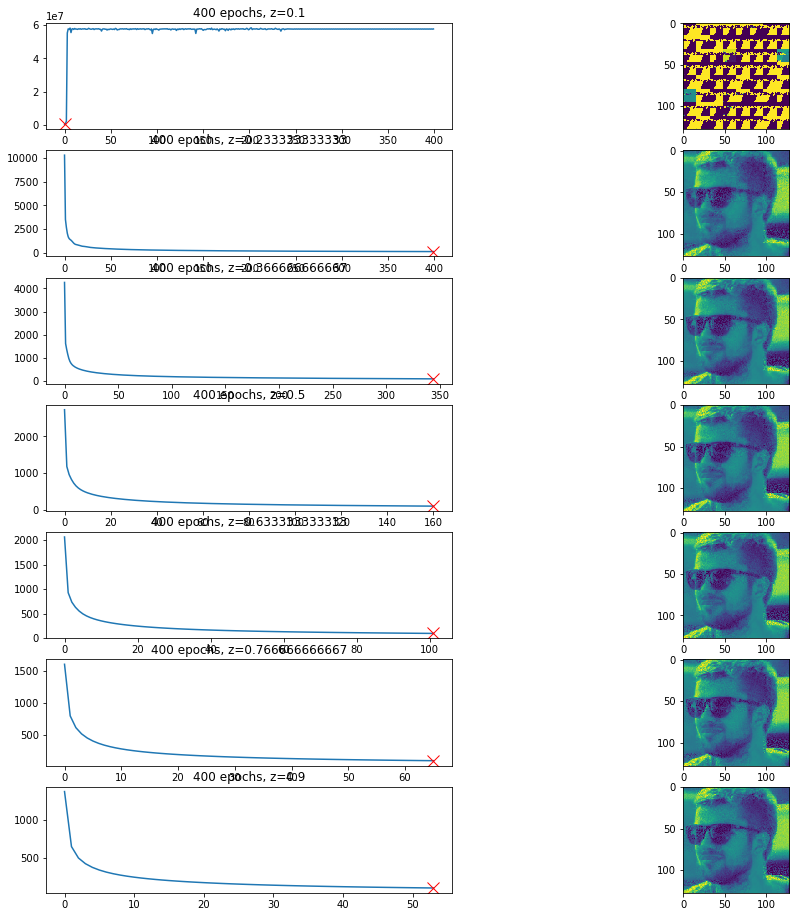

In [60]:
N_z = 7
fig, ax = plt.subplots(N_z, 2, figsize=(16, 16))
for i, z in enumerate(np.linspace(0.1, 0.9, N_z)):
    print 'Running for z={}'.format(z)
    epochs = 400
    model = Autoencoder(input_layers=N, z=z)
    best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, ax=ax[i][0])
    new_pic = viz_encode(model, best_results)
    ax[i][1].imshow(new_pic)
    print 'Min Error:', best_results['min_err']

Зависимость количества эпох от коэффициента сжатия `Z`. Фиксированные параметры:
- `th_err`: 200.0
- `epochs`: 600
- `dynamic_lr`: True

  0%|          | 28/192000 [00:00<11:42, 273.16it/s]

running for z=0.95


  0%|          | 42/192000 [00:00<07:45, 412.19it/s]

Error: 9.99581898821
running for z=0.902631578947


  0%|          | 41/192000 [00:00<07:52, 406.30it/s]

Error: 9.99524955959
running for z=0.855263157895


  0%|          | 41/192000 [00:00<08:01, 399.00it/s]

Error: 9.997741394
running for z=0.807894736842


  0%|          | 41/192000 [00:00<07:54, 404.51it/s]

Error: 9.99297610888
running for z=0.760526315789


  0%|          | 47/192000 [00:00<06:49, 468.57it/s]

Error: 9.99848330214
running for z=0.713157894737


  0%|          | 30/192000 [00:00<10:50, 295.21it/s]

Error: 9.99799888912
running for z=0.665789473684


  0%|          | 51/192000 [00:00<06:24, 499.44it/s]

Error: 9.99838696999
running for z=0.618421052632


  0%|          | 49/192000 [00:00<06:36, 484.72it/s]

Error: 9.99645728677
running for z=0.571052631579


  0%|          | 44/192000 [00:00<07:19, 437.16it/s]

Error: 9.998165406
running for z=0.523684210526


  0%|          | 46/192000 [00:00<07:02, 453.84it/s]

Error: 9.99831311216
running for z=0.476315789474


  0%|          | 58/192000 [00:00<05:36, 570.69it/s]

Error: 11.5749577847
running for z=0.428947368421


  0%|          | 49/192000 [00:00<06:33, 487.27it/s]

Error: 14.366996714
running for z=0.381578947368


  0%|          | 59/192000 [00:00<05:33, 574.96it/s]

Error: 19.2026123221
running for z=0.334210526316


  0%|          | 53/192000 [00:00<06:12, 515.59it/s]

Error: 33.459770715
running for z=0.286842105263


  0%|          | 34/192000 [00:00<09:26, 338.84it/s]

Error: 49.6575428267
running for z=0.239473684211


  0%|          | 55/192000 [00:00<05:55, 539.37it/s]

Error: 77.160676679
running for z=0.192105263158


  0%|          | 63/192000 [00:00<05:05, 628.82it/s]

Error: 121.579647134
running for z=0.144736842105


  0%|          | 66/192000 [00:00<04:51, 658.45it/s]

Error: 239.612799344
running for z=0.0973684210526


  0%|          | 83/192000 [00:00<03:51, 829.06it/s]

Error: 258169.464963
running for z=0.05


100%|██████████| 192000/192000 [00:53<00:00, 3613.97it/s]


Error: 5058785.68297


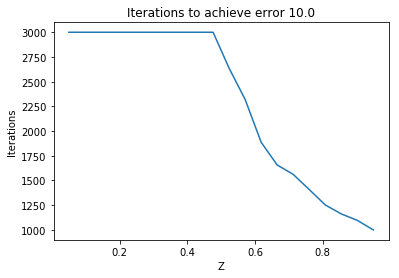

In [145]:
N_z = 20
zs = np.linspace(0.05, 0.95, N_z)
MAX_EPOCHS = 3000
TH_ERR = 10.0

epochs = np.array([])
for z in zs[::-1]:
    print 'running for z={}'.format(z)
    model = Autoencoder(input_layers=N, z=z)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error:', best_results['min_err']
    
plt.plot(zs[::-1], epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Z')
plt.ylabel('Iterations')
plt.show()

Зависимость количества эпох от пороговой ошибки. Фиксированные параметры:
- `z`: 0.6
- `epoch`: 3000
- `dynamic_lr`: True

  0%|          | 34/192000 [00:00<09:55, 322.09it/s]

running for thr_err=30.0


 21%|██        | 39936/192000 [00:48<03:04, 822.98it/s]


running for thr_err=27.7777777778


  0%|          | 52/192000 [00:00<06:09, 519.80it/s]

running for thr_err=25.5555555556


  0%|          | 50/192000 [00:00<06:31, 490.76it/s]

running for thr_err=23.3333333333


  0%|          | 48/192000 [00:00<06:44, 474.07it/s]

running for thr_err=21.1111111111


  0%|          | 49/192000 [00:00<06:36, 484.20it/s]

running for thr_err=18.8888888889


  0%|          | 49/192000 [00:00<06:43, 475.51it/s]

running for thr_err=16.6666666667


  0%|          | 47/192000 [00:00<06:51, 466.82it/s]

running for thr_err=14.4444444444


  0%|          | 44/192000 [00:00<07:29, 427.26it/s]

running for thr_err=12.2222222222


  0%|          | 39/192000 [00:00<08:16, 387.00it/s]

running for thr_err=10.0


 71%|███████▏  | 137216/192000 [02:58<01:11, 770.20it/s]


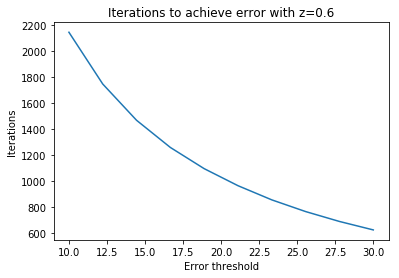

In [147]:
N_thr = 10
thrs = np.linspace(10.0, 30.0, N_thr)
MAX_EPOCHS = 3000
Z = 0.6
epochs = np.array([])
for thr in thrs[::-1]:
    print 'running for thr_err={}'.format(thr)
    model = Autoencoder(input_layers=N, z=Z)
    best_results = try_run(model, MAX_EPOCHS, th_err=thr, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    
plt.plot(thrs[::-1], epochs)
plt.title('Iterations to achieve error with z={}'.format(Z))
plt.xlabel('Error threshold')
plt.ylabel('Iterations')
plt.show()

Зависимость количества эпох от коэффициента обучения (`learning rate`). Исходя из проведенных исследований, определим границы для него $[1e^{-6}..1e^{-2}]$. Фиксированные параметры:
- `z`: 0.6
- `th_err`: 10.0
- `epoch`: 3000

  0%|          | 40/192000 [00:00<08:05, 395.29it/s]

running for alpha=0.01


  0%|          | 45/192000 [00:00<07:12, 444.16it/s]

Error:  89399836.4426
running for alpha=0.00947373684211


  0%|          | 44/192000 [00:00<07:21, 434.62it/s]

Error:  88478629.5696
running for alpha=0.00894747368421


  0%|          | 48/192000 [00:00<06:41, 477.96it/s]

Error:  87174296.8514
running for alpha=0.00842121052632


  0%|          | 39/192000 [00:00<08:15, 387.71it/s]

Error:  86681880.4466
running for alpha=0.00789494736842


  0%|          | 45/192000 [00:00<07:07, 448.95it/s]

Error:  30823419.23
running for alpha=0.00736868421053


  0%|          | 46/192000 [00:00<06:58, 458.20it/s]

Error:  30507693.4756
running for alpha=0.00684242105263


  0%|          | 45/192000 [00:00<07:08, 447.84it/s]

Error:  109917.097478
running for alpha=0.00631615789474


  0%|          | 43/192000 [00:00<07:27, 428.87it/s]

Error:  9.76079183172
running for alpha=0.00578989473684


  0%|          | 45/192000 [00:00<07:11, 444.63it/s]

Error:  9.99386879154
running for alpha=0.00526363157895


  0%|          | 47/192000 [00:00<06:56, 461.39it/s]

Error:  9.87008572729
running for alpha=0.00473736842105


  0%|          | 44/192000 [00:00<07:18, 437.32it/s]

Error:  9.99978407562
running for alpha=0.00421110526316


  0%|          | 47/192000 [00:00<06:49, 468.41it/s]

Error:  9.97077184207
running for alpha=0.00368484210526


  0%|          | 44/192000 [00:00<07:18, 438.23it/s]

Error:  9.98614946326
running for alpha=0.00315857894737


  0%|          | 47/192000 [00:00<06:51, 466.46it/s]

Error:  9.96695472801
running for alpha=0.00263231578947


  0%|          | 33/192000 [00:00<09:53, 323.61it/s]

Error:  9.95024961956
running for alpha=0.00210605263158


  0%|          | 48/192000 [00:00<06:40, 478.74it/s]

Error:  9.96597159446
running for alpha=0.00157978947368


  0%|          | 49/192000 [00:00<06:33, 487.93it/s]

Error:  9.97304398247
running for alpha=0.00105352631579


  0%|          | 42/192000 [00:00<07:39, 417.71it/s]

Error:  9.98992659578
running for alpha=0.000527263157895


  0%|          | 46/192000 [00:00<07:05, 451.52it/s]

Error:  9.99676381978
running for alpha=1e-06


100%|██████████| 192000/192000 [04:01<00:00, 795.35it/s]


Error:  512.056742628


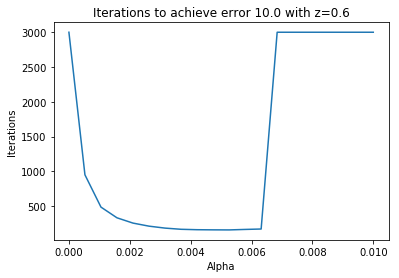

In [148]:
N_alpha = 20
alphas = np.linspace(1e-6, 1e-2, N_alpha)
MAX_EPOCHS = 3000
Z = 0.6
TH_ERR = 10.0
epochs = np.array([])
for alpha in alphas[::-1]:
    print 'running for alpha={}'.format(alpha)
    model = Autoencoder(input_layers=N, z=Z, lr=alpha, dynamic_lr=False)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error: ', best_results['min_err']
    
plt.plot(alphas[::-1], epochs)
plt.title('Iterations to achieve error {} with z={}'.format(TH_ERR, Z))
plt.xlabel('Alpha')
plt.ylabel('Iterations')
plt.show()

Зависимость количество эпох от картинки. Всего имеется $8$ картинок, для них и будут проведены тесты.
Фиксированные параметры:
- `z`: 0.6
- `epoch`: 3000
- `th_err`: 10.0
- `dynamic_lr`: True

  0%|          | 34/192000 [00:00<09:26, 338.90it/s]

running for image # 1 cornell_box_04.jpg


  0%|          | 45/192000 [00:00<07:19, 437.03it/s]

Error:  69.8304169301
running for image # 2 Reddeadredemption_agentedgarross_256x256.jpg


  0%|          | 46/192000 [00:00<07:03, 453.71it/s]

Error:  69.9645926085
running for image # 3 Paper Mario.png


  0%|          | 45/192000 [00:00<07:10, 445.71it/s]

Error:  69.9844412457
running for image # 4 Haydn-Jones.jpg


  0%|          | 48/192000 [00:00<06:42, 476.44it/s]

Error:  69.978240198
running for image # 5 NettyScribble.jpg


  0%|          | 45/192000 [00:00<07:11, 444.95it/s]

Error:  69.9098878019
running for image # 6 Avatar_256x256.jpg


  0%|          | 49/192000 [00:00<06:36, 483.98it/s]

Error:  69.9997133819
running for image # 7 img1.jpg


  0%|          | 51/192000 [00:00<06:19, 506.18it/s]

Error:  69.9783549459
running for image # 8 baboon.jpg


  3%|▎         | 5952/192000 [00:06<03:20, 929.79it/s]


Error:  69.3002667239


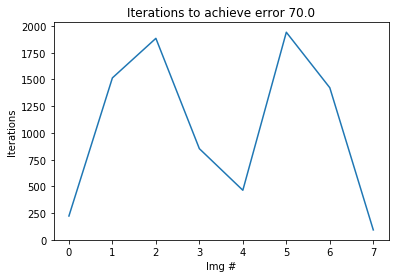

In [151]:
Z = 0.6
MAX_EPOCHS = 3000
TH_ERR = 70.0
epochs = np.array([])
imgs = list(next(walk('./pics/'))[2])

def custom_pic_gen(path):
    im = load_image(path)
    return transform_image(im, n, m)

for idx, img in enumerate(imgs):
    print 'running for image #', idx + 1, img
    model = Autoencoder(input_layers=N, z=Z)
    best_results = try_run(model, MAX_EPOCHS, gen=custom_pic_gen('./pics/{}'.format(img)), th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error: ', best_results['min_err']
    
plt.plot(range(len(imgs)), epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Img #')
plt.ylabel('Iterations')
plt.show()

 32%|███▎      | 8320/25600 [00:04<00:09, 1890.70it/s]


BEST ERROR 99.6670093453 at 129


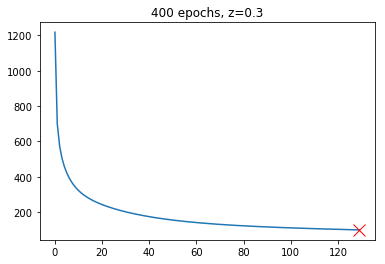

Showing results for min_err=99.6670093453. Epoch run: 130


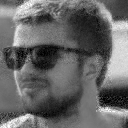

In [61]:
z = 0.3
epochs = 400
model = Autoencoder(input_layers=N, z=z, w_norm=False, dynamic_lr=True)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 25600/25600 [00:20<00:00, 1219.13it/s]


BEST ERROR 327.153841821 at 399


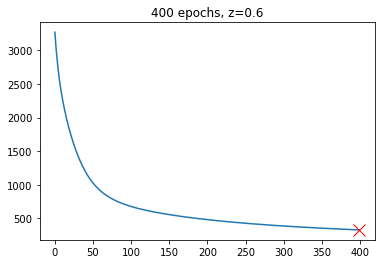

Showing results for min_err=327.153841821. Epoch run: 400


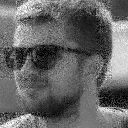

In [62]:
z = 0.6
epochs = 400
model = Autoencoder(input_layers=N, z=z, w_norm=False, dynamic_lr=False, lr=1e-5)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 25600/25600 [00:28<00:00, 912.38it/s]


BEST ERROR 1592.48848455 at 399


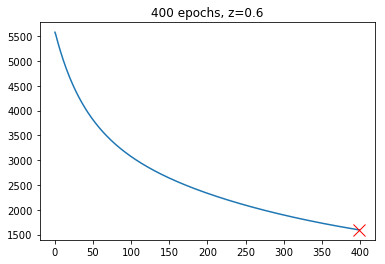

Showing results for min_err=1592.48848455. Epoch run: 400


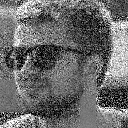

In [63]:
z = 0.6
epochs = 400
model = Autoencoder(input_layers=N, z=z, w_norm=True, dynamic_lr=False, lr=1e-6)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic

  0%|          | 45/25600 [00:00<00:56, 449.19it/s]

Running for lr=1e-07


100%|██████████| 25600/25600 [00:28<00:00, 910.07it/s]


BEST ERROR 4052.31714254 at 399
Showing results for min_err=4052.31714254. Epoch run: 400


  0%|          | 36/25600 [00:00<01:11, 358.87it/s]

Running for lr=2.575e-06


100%|██████████| 25600/25600 [00:28<00:00, 907.30it/s]


BEST ERROR 898.815850835 at 399
Showing results for min_err=898.815850835. Epoch run: 400


  0%|          | 37/25600 [00:00<01:10, 364.44it/s]

Running for lr=5.05e-06


100%|██████████| 25600/25600 [00:27<00:00, 917.66it/s]


BEST ERROR 637.901935438 at 399
Showing results for min_err=637.901935438. Epoch run: 400
Running for lr=7.525e-06


100%|██████████| 25600/25600 [00:27<00:00, 916.35it/s]


BEST ERROR 511.701254266 at 399
Showing results for min_err=511.701254266. Epoch run: 400


  0%|          | 39/25600 [00:00<01:06, 383.59it/s]

Running for lr=1e-05


100%|██████████| 25600/25600 [00:27<00:00, 916.70it/s]


BEST ERROR 434.294139309 at 399
Showing results for min_err=434.294139309. Epoch run: 400


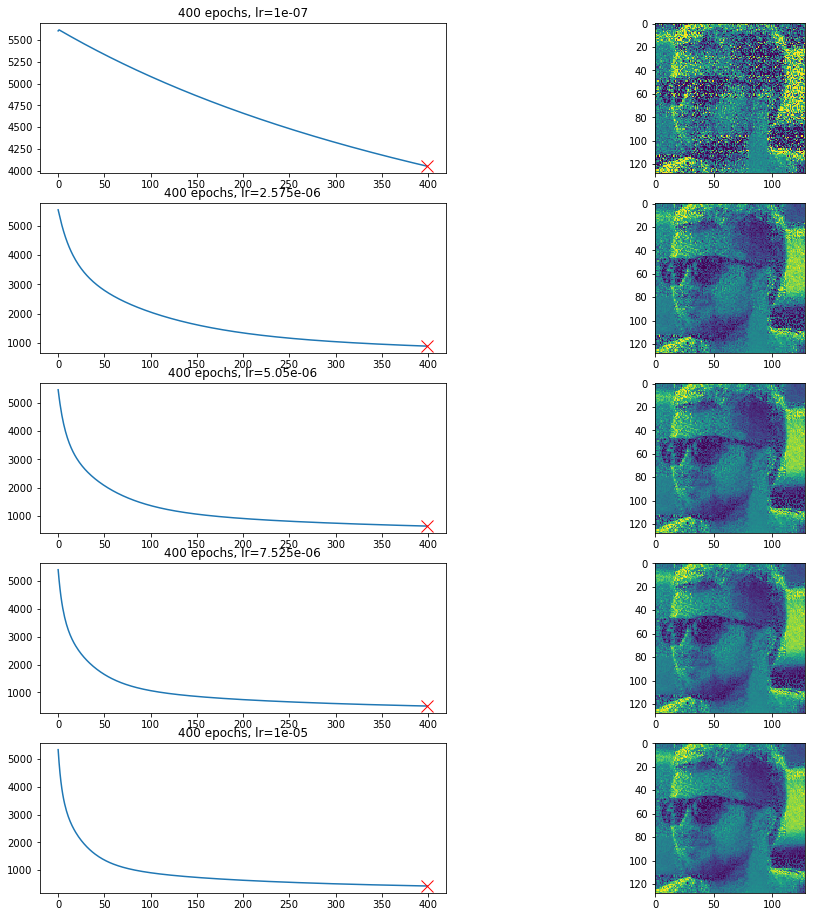

In [64]:
z = 0.6
lrs = np.linspace(1e-7, 1e-5, 5)
fig, ax = plt.subplots(lrs.shape[0], 2, figsize=(16, 16))
for i, lr in enumerate(lrs):
    print 'Running for lr={}'.format(lr)
    epochs = 400
    model = Autoencoder(input_layers=N, z=z, dynamic_lr=False, w_norm=True, lr=lr)
    best_results = try_run(model, epochs, '{} epochs, lr={}'.format(epochs, lr), th_err=100.0, ax=ax[i][0])
    new_pic = viz_encode(model, best_results)
    ax[i][1].imshow(new_pic)

100%|██████████| 102400/102400 [01:54<00:00, 894.43it/s]


BEST ERROR 323.966807429 at 399


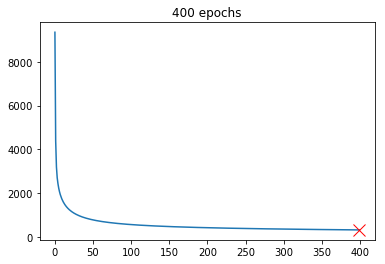

Showing results for min_err=323.966807429. Epoch run: 400


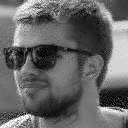

In [65]:
imgs = next(walk('./pics/'))[2]
epochs = 400
T = len(imgs)
model = Autoencoder(input_layers=N, z=0.6)

def get_multi_gen():
    for i in range(T):
        path = './pics/{}'.format(imgs[i])
        im = load_image(path)
        for part in transform_image(im, n, m):
            yield part

best_results = try_run(model, epochs, '{} epochs'.format(epochs), gen=get_multi_gen(), th_err=100.0, L=L*T)
new_pic = viz_encode(model, best_results)
new_pic

100%|██████████| 102400/102400 [01:53<00:00, 898.71it/s]


BEST ERROR 323.966807429 at 399


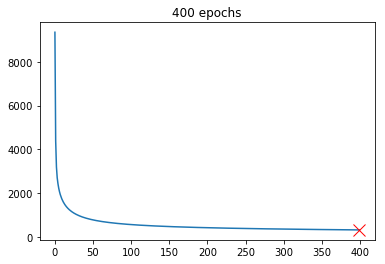

Showing results for min_err=323.966807429. Epoch run: 400


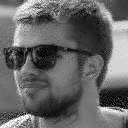

In [66]:
imgs = next(walk('./pics/'))[2]
epochs = 400
T = len(imgs)
model = Autoencoder(input_layers=N, z=0.6)

def get_multi_gen():
    for i in range(T):
        path = './pics/{}'.format(imgs[i])
        im = load_image(path)
        for part in transform_image(im, n, m):
            yield part

best_results = try_run(model, epochs, '{} epochs'.format(epochs), gen=get_multi_gen(), th_err=100.0, L=L*T)
new_pic = viz_encode(model, best_results)
new_pic

In [67]:
next(walk('./pics/'))[2]

['cornell_box_04.jpg', 'Haydn-Jones.jpg', 'NettyScribble.jpg', 'baboon.jpg']

In [68]:
# 3) glorot function from?

 26%|██▋       | 6720/25600 [00:07<00:22, 857.09it/s]


BEST ERROR 99.8090739209 at 104


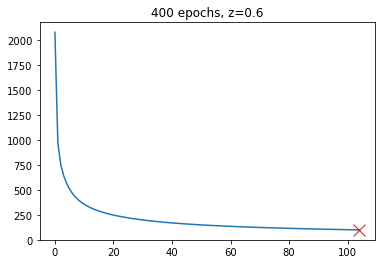

Showing results for min_err=99.8090739209. Epoch run: 105


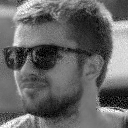

In [69]:
z = 0.6
epochs = 400
model = Autoencoder(input_layers=N, z=z)
best_results = try_run(model, epochs, '{} epochs, z={}'.format(epochs, z), th_err=100.0, viz=True)
new_pic = viz_encode(model, best_results)
new_pic